In [14]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


Loaded 2219 images


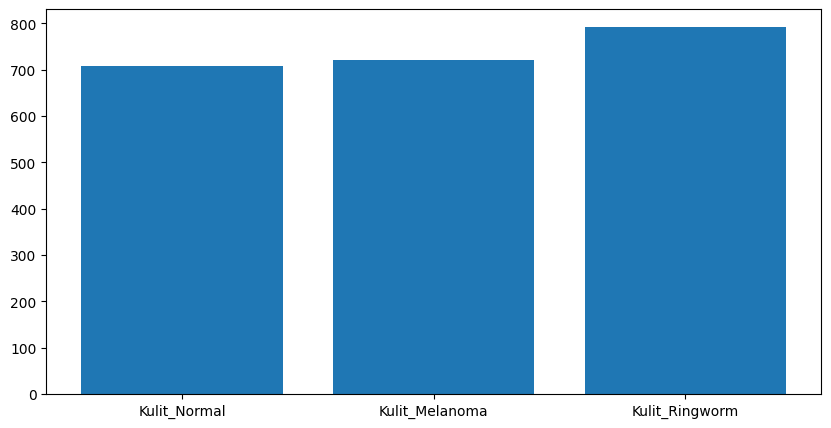

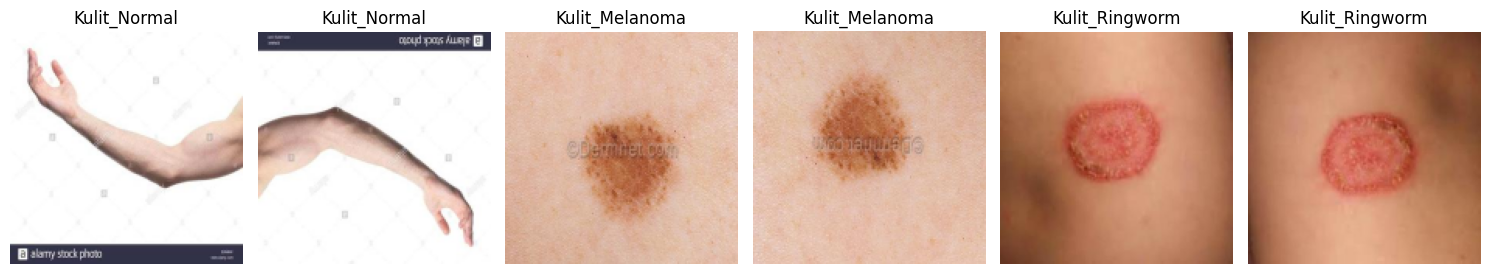

In [15]:
def load(folders):
    target_size = (150, 150)
    sample_count = 2
    images = []
    labels = []
    count = {}
    sample = {folder: [] for folder in folders} 
    
    for folder_path in folders:
        folder_name = os.path.basename(folder_path)
        count[folder_name] = 0
        
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = cv.imread(img_path)
            if img is not None:
                img = cv.resize(img, target_size)
                images.append(img)
                label = folder_name  
                labels.append(label)
                
                count[folder_name] += 1
                
                if len(sample[folder_name]) < sample_count: 
                    sample[folder_name].append(img)
    
    return images, labels, count, sample

f1 = 'Kulit_Normal'
f2 = 'Kulit_Melanoma'
f3 = 'Kulit_Ringworm'


images, labels, count, sample = load([f1, f2, f3])


print(f"Loaded {len(images)} images")

plt.figure(figsize=(10, 5))
plt.bar(count.keys(), count.values())
plt.show()


fig, axs = plt.subplots(1, len([f1, f2, f3]) * 2, figsize=(15, 5))
axs = axs.flatten()
for i, folder in enumerate([f1, f2, f3]):
    for j in range(2):
        index = i * 2 + j
        if j < len(sample[folder]):
            axs[index].imshow(cv.cvtColor(sample[folder][j], cv.COLOR_BGR2RGB))
            axs[index].set_title(f"{folder}")   
        axs[index].axis('off')

plt.tight_layout()
plt.show()

In [16]:
def derajat(img, angle):
    max_val = np.max(img)
    temp = np.zeros([max_val + 1, max_val + 1])

    if angle == 0:
        temp[img[:, :-1], img[:, 1:]] += 1
    elif angle == 45:
        temp[img[:-1, 1:], img[1:, :-1]] += 1
    elif angle == 90:
        temp[img[:-1, :], img[1:, :]] += 1
    elif angle == 135:
        temp[img[:-1, :-1], img[1:, 1:]] += 1

    data = temp + temp.T
    data /= np.sum(data)

    return data

def gabung(image):
    features = []
    angles = [0, 45, 90, 135]

    for img in image:
        data = [derajat(img, angle) for angle in angles]
        features.append(data)

    return features

def hitung(data):
    features = {}
    i_indices, j_indices = np.indices(data.shape)
    features['kontras'] = np.sum((i_indices - j_indices) ** 2 * data)
    features['dissimilarity'] = np.sum(np.abs(i_indices - j_indices) * data)
    features['homogenitas'] = np.sum(data / (1 + (i_indices - j_indices) ** 2))
    non_zero_elements = data[data > 0.0]
    features['entropy'] = -np.sum(non_zero_elements * np.log(non_zero_elements))
    features['energy'] = np.sum(data ** 2)
    features['asm'] = np.sum(data ** 2)
    features['korelasi'] = korelasi(data)
    return features


def korelasi(data):
    jumlahBaris, jumlahKolom = data.shape
    i_indices, j_indices = np.indices(data.shape)
    sumIJ = np.sum(i_indices * j_indices * data)
    sumI = np.sum(i_indices * data)
    sumJ = np.sum(j_indices * data)
    sumI_squared = np.sum((i_indices - sumI) ** 2 * data)
    sumJ_squared = np.sum((j_indices - sumJ) ** 2 * data)

    std_i = np.sqrt(sumI_squared)
    std_j = np.sqrt(sumJ_squared)

    if std_i != 0 and std_j != 0:
        kor = (sumIJ - sumI * sumJ) / (std_i * std_j)
    else:
        kor = 0

    return kor

def ekstraksi(data, label):
    features = gabung(data)
    angles = ['0', '45', '90', '135']
    result = []
    n = 1000

    for j in tqdm(range(min(len(features), n)), desc=f'Ekstraksi fitur untuk {label}'):
        eksfitur = [label] 

        for i in features[j]:
            feature_values = hitung(i)
            eksfitur.append(feature_values['kontras'])
            eksfitur.append(feature_values['dissimilarity'])
            eksfitur.append(feature_values['homogenitas'])
            eksfitur.append(feature_values['entropy'])
            eksfitur.append(feature_values['energy'])  
            eksfitur.append(feature_values['asm']) 
            eksfitur.append(feature_values['korelasi'])

        result.append(eksfitur)

    headers = ['path']
    for angle in angles:
        headers.extend([f'kontras{angle}', f'dissimilarity{angle}', f'homogenitas{angle}', f'entropi{angle}', f'asm{angle}', f'energi{angle}', f'correlation{angle}'])

    df = pd.DataFrame(result, columns=headers)

    csv_path = f'result_csv/Sebelum Preprocessing pada{label}.csv'
    df.to_csv(csv_path, index=False)
    return df
ekstraksi([img for img, label in zip(images, labels) if label == f1], 'Kulit_Normal')


Ekstraksi fitur untuk Kulit_Normal: 100%|██████████| 707/707 [00:03<00:00, 220.92it/s]


,path,kontras0,dissimilarity0,homogenitas0,entropi0,asm0,energi0,correlation0,kontras45,dissimilarity45,...,asm90,energi90,correlation90,kontras135,dissimilarity135,homogenitas135,entropi135,asm135,energi135,correlation135
0,Kulit_Normal,1247.436635,21.667275,0.084191,9.127017,0.000115,0.000115,0.809536,2273.654362,31.382807,...,0.000103,0.000103,0.775229,1732.048371,25.842966,0.069004,9.244277,0.000103,0.000103,0.746227
1,Kulit_Normal,1233.988558,21.552544,0.084047,9.136367,0.000114,0.000114,0.813203,2213.760487,30.955519,...,0.000103,0.000103,0.782172,1671.079614,25.301928,0.071230,9.243296,0.000103,0.000103,0.757471
2,Kulit_Normal,1255.609551,21.595819,0.085425,9.125203,0.000115,0.000115,0.809307,1719.287134,25.668691,...,0.000103,0.000103,0.780162,2226.499620,31.048669,0.059758,9.392754,0.000088,0.000088,0.672185
3,Kulit_Normal,1226.261049,21.442881,0.084601,9.127396,0.000115,0.000115,0.813591,1670.244135,25.376898,...,0.000103,0.000103,0.779706,2214.584660,30.944781,0.060082,9.395658,0.000088,0.000088,0.674815
4,Kulit_Normal,1255.609551,21.595819,0.085425,9.125203,0.000115,0.000115,0.809307,1719.287134,25.668691,...,0.000103,0.000103,0.780162,2226.499620,31.048669,0.059758,9.392754,0.000088,0.000088,0.672185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,Kulit_Normal,1004.792424,17.001094,0.099917,9.187634,0.000108,0.000108,0.897475,1914.920688,24.967648,...,0.000111,0.000111,0.885936,1177.636860,19.593454,0.086703,9.319366,0.000095,0.000095,0.877979
703,Kulit_Normal,1008.810286,17.033511,0.099975,9.184501,0.000108,0.000108,0.896642,1894.210982,24.790209,...,0.000110,0.000110,0.887143,1172.333690,19.579736,0.087008,9.320202,0.000095,0.000095,0.879563
704,Kulit_Normal,1004.792424,17.001094,0.099917,9.187634,0.000108,0.000108,0.897475,1914.920688,24.967648,...,0.000111,0.000111,0.885936,1177.636860,19.593454,0.086703,9.319366,0.000095,0.000095,0.877979
705,Kulit_Normal,570.940786,14.264176,0.107731,9.087903,0.000119,0.000119,0.940721,1309.794098,19.798050,...,0.000104,0.000104,0.885404,1349.404096,19.879518,0.085629,9.332921,0.000094,0.000094,0.861621


In [17]:
ekskulit1 = ekstraksi([img for img, label in zip(images, labels) if label == f1], 'Kulit_Normal')
ekskulit2 = ekstraksi([img for img, label in zip(images, labels) if label == f2], 'Kulit_Melanoma')
ekskulit3 = ekstraksi([img for img, label in zip(images, labels) if label == f3], 'Kulit_Ringworm')

Ekstraksi fitur untuk Kulit_Ringworm: 100%|██████████| 791/791 [00:03<00:00, 210.70it/s]


In [18]:
def seleksi(dataframe, threshold=0.5):
    numdata = dataframe.drop(columns=['path'])
    corelasi = numdata.corr().abs()
    upper = corelasi.where(np.triu(np.ones(corelasi.shape), k=1).astype(bool))
    kedrop = [column for column in upper.columns if any(upper[column] > threshold)]
    return dataframe.drop(kedrop, axis=1)


dataframes = [ekskulit1, ekskulit2, ekskulit3]
seleksif1, seleksif2, seleksif3 = map(seleksi, dataframes)

print([seleksif1, seleksif2, seleksif3])

[             path     kontras0
0    Kulit_Normal  1247.436635
1    Kulit_Normal  1233.988558
2    Kulit_Normal  1255.609551
3    Kulit_Normal  1226.261049
4    Kulit_Normal  1255.609551
..            ...          ...
702  Kulit_Normal  1004.792424
703  Kulit_Normal  1008.810286
704  Kulit_Normal  1004.792424
705  Kulit_Normal   570.940786
706  Kulit_Normal   585.405914

[707 rows x 2 columns],                path    kontras0
0    Kulit_Melanoma  219.197768
1    Kulit_Melanoma  219.403662
2    Kulit_Melanoma  218.328593
3    Kulit_Melanoma  219.306411
4    Kulit_Melanoma  218.328593
..              ...         ...
716  Kulit_Melanoma  555.231792
717  Kulit_Melanoma  544.165815
718  Kulit_Melanoma  555.231792
719  Kulit_Melanoma  505.212291
720  Kulit_Melanoma  534.370185

[721 rows x 2 columns],                path    kontras0
0    Kulit_Ringworm   84.031411
1    Kulit_Ringworm   82.205896
2    Kulit_Ringworm   84.182061
3    Kulit_Ringworm   82.581096
4    Kulit_Ringworm   84.182061
.

In [19]:
def split_data(X, y, test_size=0.3, random_state=None):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

dataframes = [seleksif1, seleksif2, seleksif3]
all_data = pd.concat(dataframes, ignore_index=True)
X = all_data.drop(columns=['path']).values
y = all_data['path'].values
train_test_ratio = 0.7
test_size = 1 - train_test_ratio

X_train, X_test, y_train, y_test = split_data(X, y, test_size=test_size)

print("Jumlah data training:", len(X_train))
print("Jumlah data testing:", len(X_test))

Jumlah data training: 1553
Jumlah data testing: 666


In [20]:
scaler = MinMaxScaler()
XTrainNorm = scaler.fit_transform(X_train)
XTestNorm = scaler.transform(X_test)

In [21]:
k = 5
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(XTrainNorm, y_train)
y_pred_knn = knn_model.predict(XTestNorm)

svc_model = SVC()
imputer = SimpleImputer(strategy='mean')
XTrainImputed = imputer.fit_transform(X_train)
XTestImputed = imputer.transform(X_test)
svc_model.fit(XTrainImputed, y_train)
y_pred_svc = svc_model.predict(XTestImputed)

rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(XTrainNorm, y_train)
y_pred_rf = rf_model.predict(XTestNorm)

In [22]:
def evaluasi(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    return accuracy, precision, recall, f1

akurasiknn, presisiknn, recalknn, f1knn = evaluasi(y_test, y_pred_knn)
akurasisvc, presisisvc, recalsvc, f1svc = evaluasi(y_test, y_pred_svc)
akurasirf, presisirf, recalrf, f1rf = evaluasi(y_test, y_pred_rf)
print(f"Akurasi KNN : {akurasiknn * 100:.2f}%")
print(f"Akurasi SVC  : {akurasisvc * 100:.2f}%")
print(f"Akurasi RF  : {akurasirf * 100:.2f}%")

Akurasi KNN : 59.31%
Akurasi SVC  : 57.96%
Akurasi RF  : 60.81%


 ┌──────────┬────────────┬────────────┬────────────┬────────────┐
 |          │ Accuracy   │ Precision  │ Recall     │ F1 Score   |
 ├──────────┼────────────┼────────────┼────────────┼────────────┤
 |KNN       │ 0.59309309 │ 0.59696288 │ 0.59309309 │ 0.59186575 |
 ├──────────┼────────────┼────────────┼────────────┼────────────┤
 |SVC       │ 0.57957958 │ 0.62560363 │ 0.57957958 │ 0.57455173 |
 ├──────────┼────────────┼────────────┼────────────┼────────────┤
 |RF        │ 0.60810811 │ 0.60834395 │ 0.60810811 │ 0.60798555 |
 └──────────┴────────────┴────────────┴────────────┴────────────┘


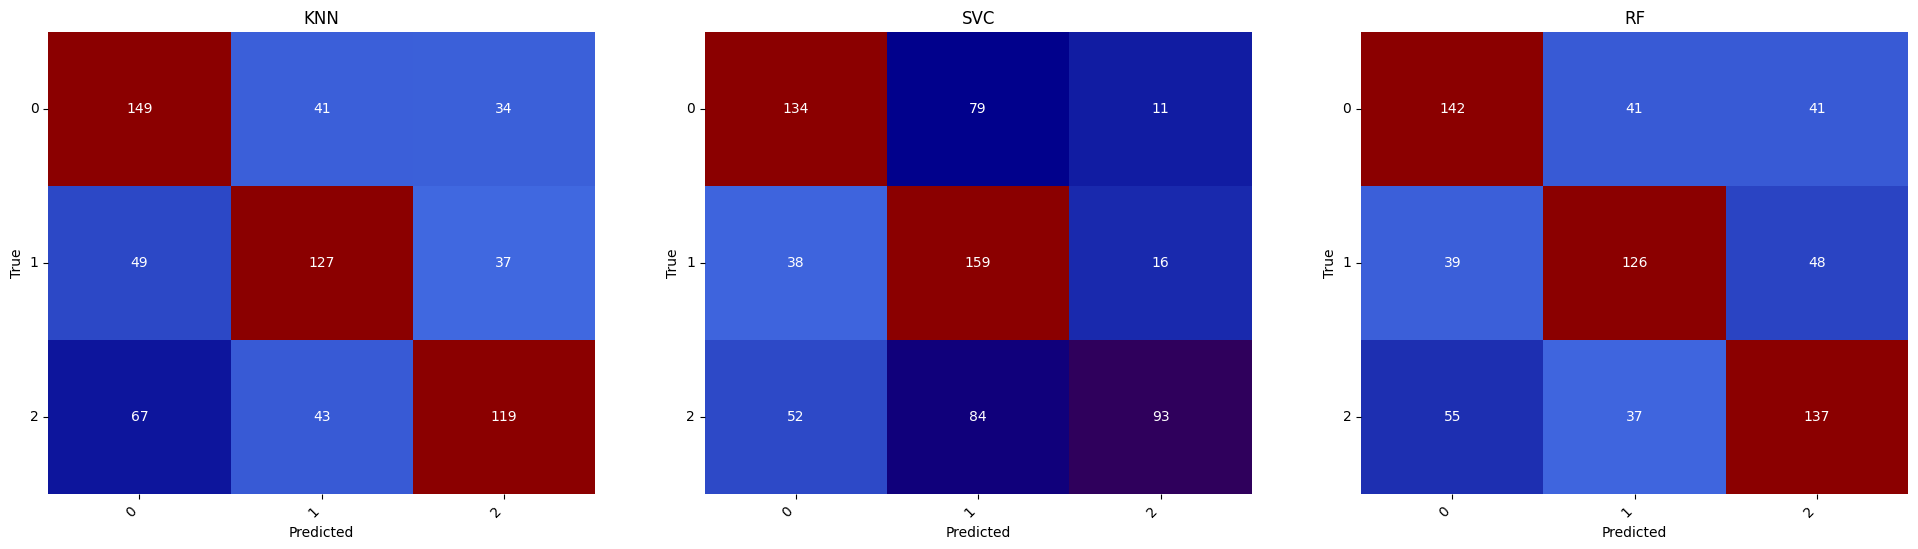

In [23]:
header = f"{' |':<10}  │ {'Accuracy':<10} │ {'Precision':<10} │ {'Recall':<10} │ {'F1 Score':<10} |"
separator = "─" * 62

top_border = f" ┌{'─' * 10}┬{'─' * 12}┬{'─' * 12}┬{'─' * 12}┬{'─' * 12}┐"
mid_border = f" ├{'─' * 10}┼{'─' * 12}┼{'─' * 12}┼{'─' * 12}┼{'─' * 12}┤"
bottom_border = f" └{'─' * 10}┴{'─' * 12}┴{'─' * 12}┴{'─' * 12}┴{'─' * 12}┘"

row_knn = f"{' |KNN':<10}  │ {akurasiknn:<10.8f} │ {presisiknn:<10.8f} │ {recalknn:<10.8f} │ {f1knn:<10.8f} |"
row_svc = f"{' |SVC':<10}  │ {akurasisvc:<10.8f} │ {presisisvc:<10.8f} │ {recalsvc:<10.8f} │ {f1svc:<10.8f} |"
row_rf = f"{' |RF':<10}  │ {akurasirf:<10.8f} │ {presisirf:<10.8f} │ {recalrf:<10.8f} │ {f1rf:<10.8f} |"

print(top_border)
print(header)
print(mid_border)
print(row_knn)
print(mid_border)
print(row_svc)
print(mid_border)
print(row_rf)
print(bottom_border)

colors = ["#00008B", "#4169E1", "#00008B", "#8B0000", "#8B0000"]
cmap = LinearSegmentedColormap.from_list("color", colors, N=256)

plt.figure(figsize=(24, 6), facecolor='None')

plt.subplot(1, 3, 1)
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, cmap=cmap, vmin=0, vmax=np.max(cm_knn), fmt='d', cbar=False)
plt.title('KNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.subplot(1, 3, 2)
cm_svc = confusion_matrix(y_test, y_pred_svc)
sns.heatmap(cm_svc, annot=True, cmap=cmap, vmin=0, vmax=np.max(cm_svc), fmt='d', cbar=False)
plt.title('SVC')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.subplot(1, 3, 3)
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, cmap=cmap, vmin=0, vmax=np.max(cm_rf), fmt='d', cbar=False)
plt.title('RF')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.show()